In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import keras.backend as K
import csv

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Data Exploration

In [3]:
## Fetch Tesla stock data from yfinance
ticker = "TSLA"
start_date = "2023-03-16"
end_date = "2024-03-16"
df = yf.download(ticker, start=start_date, end=end_date)

## Split train data and test data based on date
train_data = df.loc[:'2024-01-01'].reset_index()
test_data = df.loc['2024-01-01':].reset_index()
train_data

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-03-16,180.369995,185.809998,178.839996,184.130005,184.130005,121136800
1,2023-03-17,184.520004,186.220001,177.330002,180.130005,180.130005,133197100
2,2023-03-20,178.080002,186.440002,176.350006,183.250000,183.250000,129684400
3,2023-03-21,188.279999,198.000000,188.039993,197.580002,197.580002,153391400
4,2023-03-22,199.300003,200.660004,190.949997,191.149994,191.149994,150376400
...,...,...,...,...,...,...,...
195,2023-12-22,256.760010,258.220001,251.369995,252.539993,252.539993,93249800
196,2023-12-26,254.490005,257.970001,252.910004,256.609985,256.609985,86892400
197,2023-12-27,258.350006,263.339996,257.519989,261.440002,261.440002,106494400
198,2023-12-28,263.660004,265.130005,252.710007,253.179993,253.179993,113619900


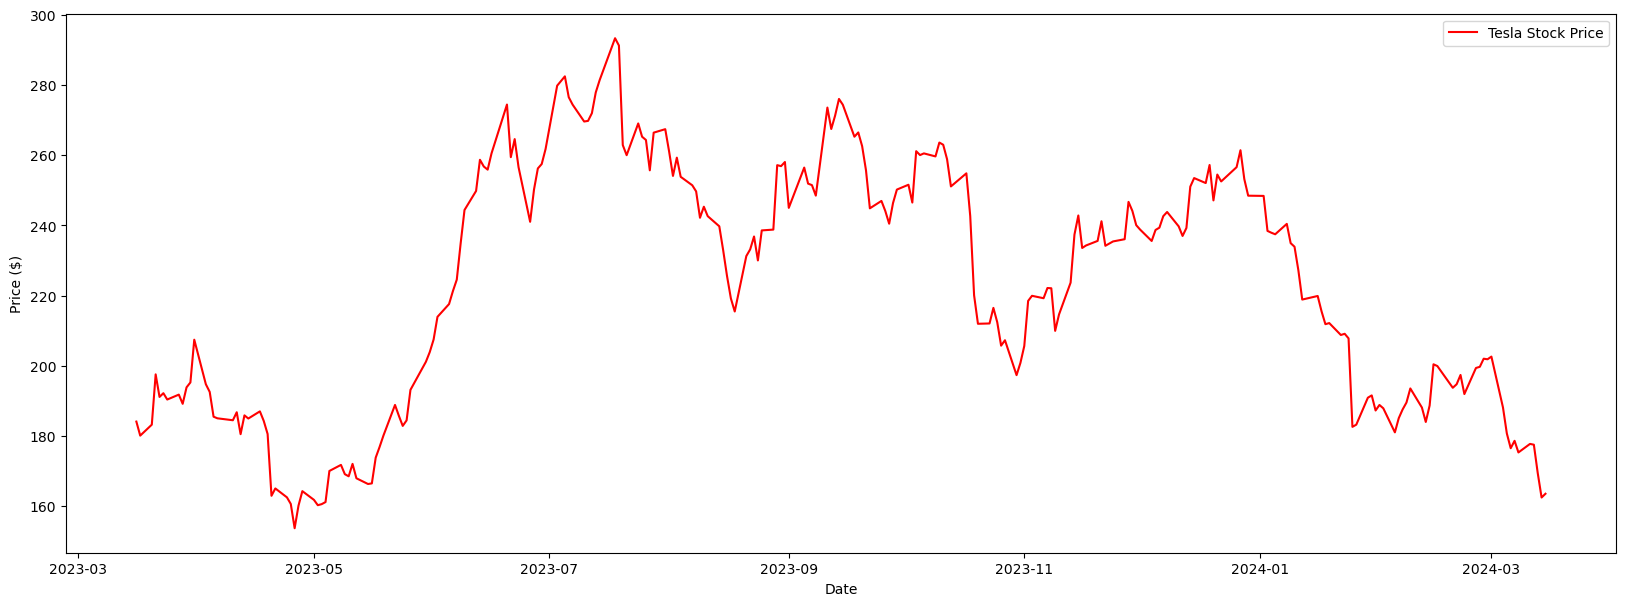

,Date,Open,High,Low,Close,Adj Close,Volume
195,2023-12-22,256.760010,258.220001,251.369995,252.539993,252.539993,93249800
196,2023-12-26,254.490005,257.970001,252.910004,256.609985,256.609985,86892400
197,2023-12-27,258.350006,263.339996,257.519989,261.440002,261.440002,106494400
198,2023-12-28,263.660004,265.130005,252.710007,253.179993,253.179993,113619900
199,2023-12-29,255.100006,255.190002,247.429993,248.479996,248.479996,100615300


In [4]:
## Visualize Tesla stock price data
plt.figure(figsize=(20, 7))
plt.plot(df.index, df['Close'].values, label='Tesla Stock Price', color='red')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()
train_data.tail()

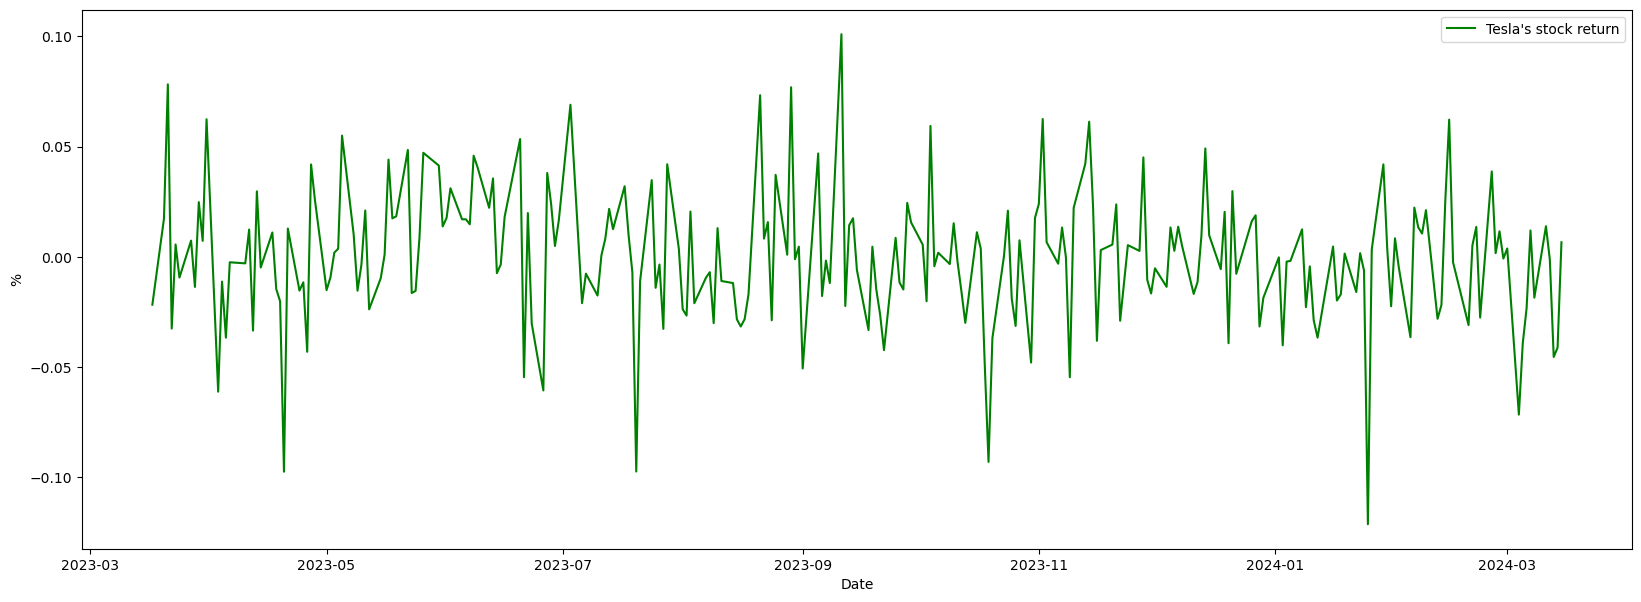

In [5]:
## Visualize Tesla Stock return
plt.figure(figsize=(20, 7))
plt.plot(df.index,df['Close'].pct_change().values, label = "Tesla's stock return", color = 'green')
plt.xlabel('Date')
plt.ylabel('%')
plt.legend()
plt.show()

# Data Preprocessing

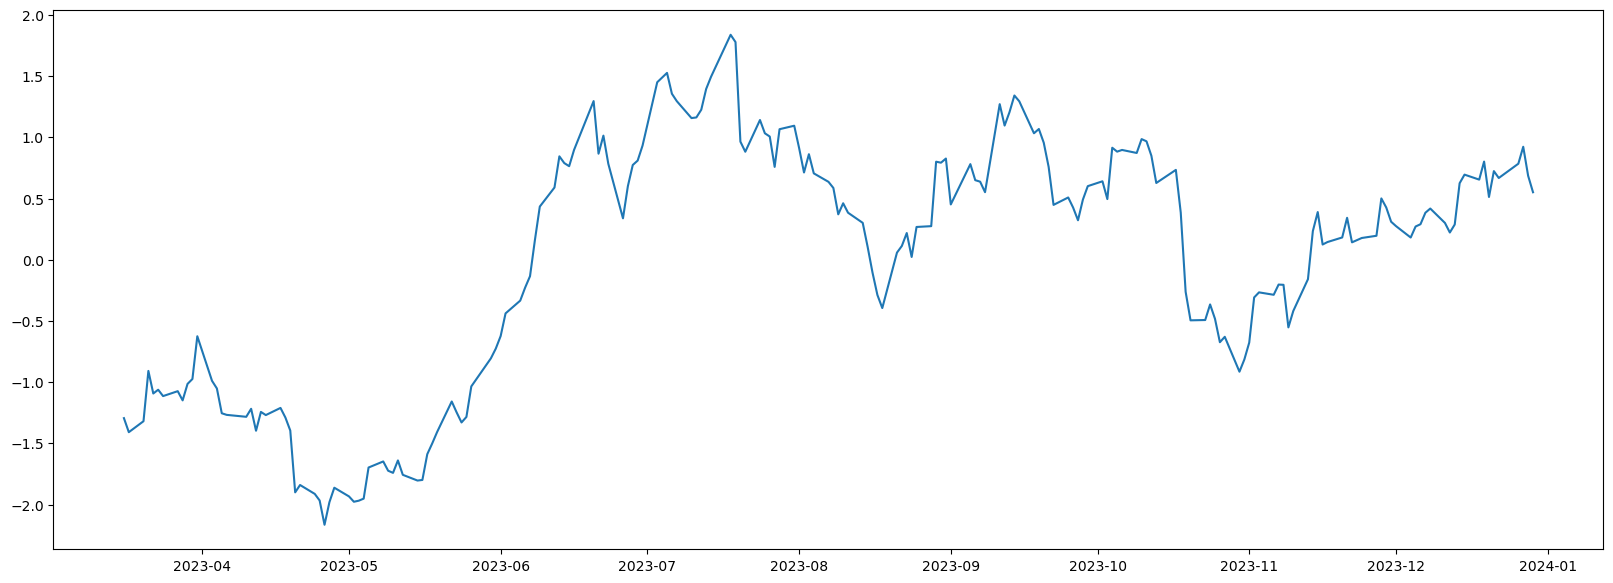

In [6]:
## Scale data
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data['Close'].values.reshape(-1,1))
plt.figure(figsize=(20, 7))
plt.plot(train_data['Date'],scaled_train_data)
plt.show()

In [7]:
# Set prediction days
prediction_days = 25
# Initialize empty lists for training data input and output
X_train = []
y_train = []

# Iterate through the scaled data, starting from the prediction_days index
for x in range(prediction_days, len(scaled_train_data)):
    # Append the previous 'prediction_days' values to x_train
    X_train.append(scaled_train_data[x - prediction_days:x, 0])
    # Append the current value to y_train
    y_train.append(scaled_train_data[x, 0])

# Convert the x_train and y_train lists to numpy arrays
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshape x_train to a 3D array with the appropriate dimensions for the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))

In [8]:
# Extract the actual closing prices from the test data
y_test = scaler.transform(test_data['Close'].values.reshape(-1, 1))

# Extract the relevant portion of the dataset for model inputs
test_data_inputs = df['Close'][len(df) - len(test_data) - prediction_days:].values

# Reshape the model inputs to a 2D array with a single column
test_data_inputs = test_data_inputs.reshape(-1, 1)

# Apply the same scaling used for training data to the model inputs
test_data_inputs = scaler.fit_transform(test_data_inputs)

In [9]:
# Initialize an empty list for test data input
X_test = []

# Iterate through the model inputs, starting from the prediction_days index
for x in range(prediction_days, len(test_data_inputs)):
    # Append the previous 'prediction_days' values to x_test
    X_test.append(test_data_inputs[x - prediction_days:x, 0])

# Convert the x_test list to a numpy array
X_test = np.array(X_test)

# Reshape x_test to a 3D array with the appropriate dimensions for the LSTM model
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Model Training

In [10]:
def LSTM_model():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """
    K.clear_session()
    # Initialize a sequential model
    model = Sequential()
# 
    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))


    
    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=25))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=6))
    model.add(Dense(units=1))

    return model

model = LSTM_model()
model.summary()
model.compile(optimizer='adam',   #this specifies the optimization algorithm to be used during training. 
    loss='mean_squared_error') #This specifies the loss function, which the model aims to minimize during training. 
              #For stock price prediction, 'mean_squared_error' is often used as the loss function. Mean Squared Error (MSE) measures the average squared difference between the predicted values and the actual values. 
    #Minimizing MSE encourages the model to make predictions that are close to the actual stock prices


#10400: Represents the number of trainable parameters in the LSTM layer.
#These parameters include weights and biases that the model learns during training.
#The number of parameters depends on the input size, output size, and other properties of the layer.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 25, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,163 (70.95 KB)

 Trainable params: 18,163 (70.95 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Define callbacks and train model

early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1)

model.fit(
    X_train, 
    y_train, 
    epochs=100, 
    batch_size = 1,
    verbose = 1,
    callbacks = [early_stop]
)

Epoch 1/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.3661
Epoch 2/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1515
Epoch 3/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1311
Epoch 4/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0990
Epoch 5/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0862
Epoch 6/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0909
Epoch 7/100
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0665
Epoch 7: early stopping


In [12]:
## Predict the result using the trained model
y_pred = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step


In [13]:
## Initialize an empty list to store predictions
y_pred_rolling = []

## Reshape the sequence to match the model input shape
first_sequence = X_test[0].reshape(1, 25, 1)

#Hold the current sequence with the predicted value appended to it
current_sequence = first_sequence

#Store all the sequences seen so far along with their predicted values
predicted_sequence = first_sequence

#Predict first sequence and add to the result list
val = model.predict(first_sequence)
y_pred_rolling.append(val.tolist()[0])

## Predict the remaining sequence
for i in range(1, X_test.shape[0]):
    current_sequence = np.append(val, current_sequence[0, 0:-1,0]) #Shift sequence by one step
    current_sequence = current_sequence.reshape(1, 25, 1)
    predicted_sequence = np.vstack((predicted_sequence,current_sequence)) #Stack vertically current sequence onto previous sequences
    val = model.predict(current_sequence)
    y_pred_rolling.append(val.tolist()[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

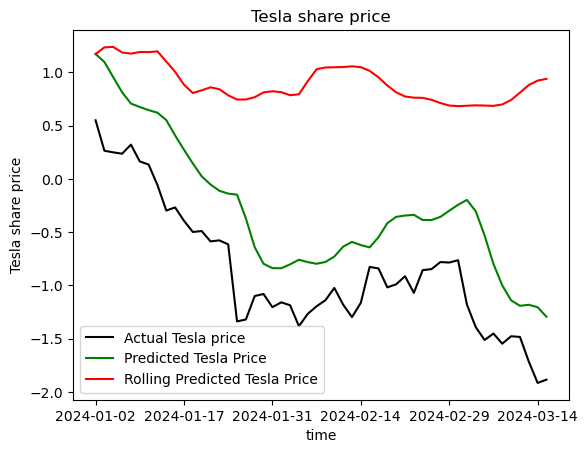

In [14]:
# Plot the actual prices using a black line
plt.plot(y_test, color='black', label="Actual Tesla price")

# Plot the predicted prices using a green line
plt.plot(y_pred, color='green', label="Predicted Tesla Price")

# Plot the rolling predicted prices using a red line
plt.plot(y_pred_rolling, color='red', label="Rolling Predicted Tesla Price")

# Set the title of the plot using the company name
plt.title("Tesla share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel("Tesla share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

plt.xticks(ticks = [i for i in range(51) if i%10==0], labels = [test_data['Date'][i].strftime('%Y-%m-%d') for i in range(51) if i%10==0])
# Show the plot on the screen
plt.show()

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
mae_pred = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae_pred)

# Calculate Mean Squared Error (MSE)
mse_pred = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse_pred = np.sqrt(mse_pred)
print("Root Mean Squared Error (RMSE):", rmse_pred)

Mean Absolute Error (MAE): 0.5697595796844429
Mean Squared Error (MSE): 0.36861293444914967
Root Mean Squared Error (RMSE): 0.6071350215966377


In [16]:
mae_rolling_pred = mean_absolute_error(y_test, y_pred_rolling)
print("Mean Absolute Error (MAE):", mae_rolling_pred)

# Calculate Mean Squared Error (MSE)
mse_rolling_pred = mean_squared_error(y_test, y_pred_rolling)
print("Mean Squared Error (MSE):", mse_rolling_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse_rolling_pred = np.sqrt(mse_rolling_pred)
print("Root Mean Squared Error (RMSE):", rmse_rolling_pred)

Mean Absolute Error (MAE): 1.7655567483699959
Mean Squared Error (MSE): 3.3697807794819985
Root Mean Squared Error (RMSE): 1.8356962655848048


# Hyperparameter Tuning

In [17]:
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters

In [18]:
def build_model(hp):
    model = Sequential()
    model.add(LSTM(hp.Int('input_unit',min_value=25,max_value=150,step=25),return_sequences=True, input_shape=(X_train.shape[1], 1)))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(LSTM(hp.Int(f'lstm_{i}_units',min_value=25,max_value=150,step=25),return_sequences=True))
    model.add(LSTM(25))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(6))
    model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.5,step=0.1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mse'])
    return model

In [19]:
tuner= kt.RandomSearch(
        build_model,
        objective='mse',
        max_trials=10,
        executions_per_trial=3,
        project_name="stock_predict_without_compound" ##change name of folder accordingly
        )

Reloading Tuner from .\stock_predict_without_compound\tuner0.json


In [20]:
tuner.search(
        x=X_train,
        y=y_train,
        epochs=20,
        batch_size=128,
        validation_data=(X_test,y_test),
        callbacks=[EarlyStopping(monitor='loss', patience=1, 
                                                restore_best_weights=True)]
)

In [21]:
best_model = tuner.get_best_models(num_models=1)[0]

In [22]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 25, 50)              │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 25, 50)              │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 25)                  │           7,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 6)                   │             156 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 6)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │               7 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,363 (149.86 KB)

 Trainable params: 38,363 (149.86 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
y_pred = best_model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 372ms/step


In [24]:
## Initialize an empty list to store predictions
y_pred_rolling = []

## Reshape the sequence to match the model input shape
first_sequence = X_test[0].reshape(1, 25, 1)

#Hold the current sequence with the predicted value appended to it
current_sequence = first_sequence

#Store all the sequences seen so far along with their predicted values
predicted_sequence = first_sequence

#Predict first sequence and add to the result list
val = best_model.predict(first_sequence)
y_pred_rolling.append(val.tolist()[0])

## Predict the remaining sequence
for i in range(1, X_test.shape[0]):
    current_sequence = np.append(val, current_sequence[0, 0:-1,0]) #Shift sequence by one step
    current_sequence = current_sequence.reshape(1, 25, 1)
    predicted_sequence = np.vstack((predicted_sequence,current_sequence)) #Stack vertically current sequence onto previous sequences
    val = best_model.predict(current_sequence)
    y_pred_rolling.append(val.tolist()[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

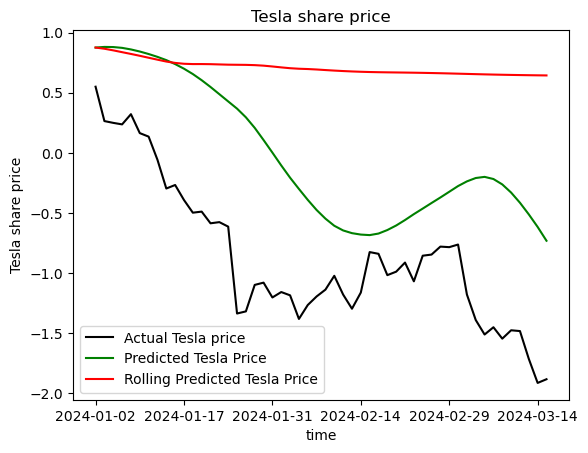

In [25]:
# Plot the actual prices using a black line
plt.plot(y_test, color='black', label="Actual Tesla price")

# Plot the predicted prices using a green line
plt.plot(y_pred, color='green', label="Predicted Tesla Price")

# Plot the rolling predicted prices using a red line
plt.plot(y_pred_rolling, color='red', label="Rolling Predicted Tesla Price")

# Set the title of the plot using the company name
plt.title("Tesla share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel("Tesla share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

plt.xticks(ticks = [i for i in range(51) if i%10==0], labels = [test_data['Date'][i].strftime('%Y-%m-%d') for i in range(51) if i%10==0])
# Show the plot on the screen
plt.show()

In [26]:
mae_pred = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae_pred)

# Calculate Mean Squared Error (MSE)
mse_pred = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse_pred = np.sqrt(mse_pred)
print("Root Mean Squared Error (RMSE):", rmse_pred)

Mean Absolute Error (MAE): 0.8456569370286403
Mean Squared Error (MSE): 0.8549991578186187
Root Mean Squared Error (RMSE): 0.9246616450456993


In [27]:
mae_pred_rolling = mean_absolute_error(y_test, y_pred_rolling)
print("Mean Absolute Error (MAE):", mae_pred_rolling)

# Calculate Mean Squared Error (MSE)
mse_pred_rolling = mean_squared_error(y_test, y_pred_rolling)
print("Mean Squared Error (MSE):", mse_pred_rolling)

# Calculate Root Mean Squared Error (RMSE)
rmse_pred_rolling = np.sqrt(mse_pred_rolling)
print("Root Mean Squared Error (RMSE):", rmse_pred_rolling)

Mean Absolute Error (MAE): 1.5777273811266694
Mean Squared Error (MSE): 2.783879451652526
Root Mean Squared Error (RMSE): 1.6684961647101637


# Combining with text data

In [28]:
## Load headlines with sentiment score
scored_news_vader = pd.read_csv('datasets/scraped_data_vader.csv',header = None)
scored_news_vader.columns = ['Date','Headline','neu','neg','pos','compound']
scored_news_vader['Date'] = pd.to_datetime(scored_news_vader['Date'])

## Calculate the daily average compound score of headlines without neu score equals to 1
scored_news_vader = pd.DataFrame(scored_news_vader[scored_news_vader['neu']!=1].groupby('Date')['compound'].agg(np.mean)).reset_index()

In [29]:
## Merge 2 datasets
df_compound = pd.merge(df,scored_news_vader,on='Date').set_index('Date')
df_compound

,Open,High,Low,Close,Adj Close,Volume,compound
Date,,,,,,,
2023-03-16,180.369995,185.809998,178.839996,184.130005,184.130005,121136800,-0.103200
2023-03-17,184.520004,186.220001,177.330002,180.130005,180.130005,133197100,-0.105744
2023-03-20,178.080002,186.440002,176.350006,183.250000,183.250000,129684400,0.071642
2023-03-21,188.279999,198.000000,188.039993,197.580002,197.580002,153391400,0.148339
2023-03-22,199.300003,200.660004,190.949997,191.149994,191.149994,150376400,-0.089313
...,...,...,...,...,...,...,...
2024-03-11,175.449997,182.869995,174.800003,177.770004,177.770004,85391500,0.069179
2024-03-12,177.770004,179.429993,172.410004,177.539993,177.539993,87391700,-0.021352
2024-03-13,173.050003,176.050003,169.149994,169.479996,169.479996,106524500,-0.011839


In [30]:
with open('datasets/stock_price_with_compound.csv', 'a', newline='',encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(df_compound.reset_index().values.tolist())

PermissionError: [Errno 13] Permission denied: 'datasets/stock_price_with_compound.csv'

In [ ]:
## Function for preprocessing
def preproc(data, lag, ratio):
    data = data.dropna().loc[:, ['Close','compound']]
    Dates = data.index.unique()
    data.iloc[:, 0] = scaler.fit_transform(data.iloc[:, 0].values.reshape(-1, 1))
    data.iloc[:, 1] = scaler.fit_transform(data.iloc[:, 1].values.reshape(-1, 1))
    for s in range(1, lag):
        data['shift_{}'.format(s)] = data.iloc[:, 0].shift(s)
    X_data = data.dropna().drop(columns = ['Close'])
    y_data = data.dropna()[['Close']]
    index = int(round(len(X_data)*ratio))
    X_data_train = X_data.iloc[:index,:]
    X_data_test = X_data.iloc[index+1:,:]
    y_data_train = y_data.iloc[:index,:]
    y_data_test = y_data.iloc[index+1:,:]
    return X_data_train,X_data_test,y_data_train,y_data_test,Dates;

In [ ]:
## Split data based on dates
a,b,c,d,Dates = preproc(df_compound, 25, 0.75)
a = a.values
b = b.values
c = c.values
d = d.values

In [ ]:
## Create train data and test data with compound
X_train_c = a.reshape(a.shape[0], a.shape[1], 1)
X_test_c = b.reshape(b.shape[0], b.shape[1], 1)
y_train_c = c
y_test_c = d

# Model Training with combined data

In [ ]:
def LSTM_model_c():
    """
    Create and configure an LSTM model for stock price prediction.

    :return: The configured LSTM model (keras.Sequential)
    """
    K.clear_session()
    # Initialize a sequential model
    model = Sequential()

    # Add the first LSTM layer with 50 units, input shape, and return sequences
    model.add(LSTM(units=50, return_sequences=True, input_shape=(a.shape[1], 1)))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

#     # Add a second LSTM layer with 50 units and return sequences
#     model.add(LSTM(units=25, return_sequences=True))
#     # Add dropout to prevent overfitting
#     model.add(Dropout(0.2))
    
    # Add a third LSTM layer with 50 units
    model.add(LSTM(units=25))
    # Add dropout to prevent overfitting
    model.add(Dropout(0.2))

    # Add a dense output layer with one unit
    model.add(Dense(units=6))
    model.add(Dense(units=1))
    return model

model_c = LSTM_model_c()
model_c.summary()
model_c.compile(optimizer='adam',   #this specifies the optimization algorithm to be used during training. 
    loss='mean_squared_error') #This specifies the loss function, which the model aims to minimize during training. 
              #For stock price prediction, 'mean_squared_error' is often used as the loss function. Mean Squared Error (MSE) measures the average squared difference between the predicted values and the actual values. 
    #Minimizing MSE encourages the model to make predictions that are close to the actual stock prices


#10400: Represents the number of trainable parameters in the LSTM layer.
#These parameters include weights and biases that the model learns during training.
#The number of parameters depends on the input size, output size, and other properties of the layer.

In [ ]:
model_c.fit(
    X_train_c, 
    y_train_c, 
    epochs=100, 
    batch_size = 1,
    verbose = 1,
    callbacks = [early_stop]
)

In [ ]:
y_pred_c = model_c.predict(X_test_c)

In [ ]:
## Initialize an empty list to store predictions
y_pred_c_rolling = []

## Reshape the sequence to match the model input shape
first_sequence = X_test_c[0].reshape(1, 25, 1)

#Hold the current sequence with the predicted value appended to it
current_sequence = first_sequence

#Store all the sequences seen so far along with their predicted values
predicted_sequence = first_sequence

#Predict first sequence and add to the result list
val = model_c.predict(first_sequence)
y_pred_c_rolling.append(val.tolist()[0])

## Predict the remaining sequence
for i in range(1, X_test_c.shape[0]):
    current_sequence = np.append(val, current_sequence[0, 0:-1,0]) #Shift sequence by one step
    current_sequence = current_sequence.reshape(1, 25, 1)
    predicted_sequence = np.vstack((predicted_sequence,current_sequence)) #Stack vertically current sequence onto previous sequences
    val = model_c.predict(current_sequence)
    y_pred_c_rolling.append(val.tolist()[0])

In [ ]:
# Plot the actual prices using a black line
plt.plot(y_test_c, color='black', label="Actual Tesla price")

# Plot the predicted prices using a green line
plt.plot(y_pred_c, color='green', label="Predicted Tesla Price")

# Plot the rolling predicted prices using a red line
plt.plot(y_pred_c_rolling, color='red', label="Rolling Predicted Tesla Price")

# Set the title of the plot using the company name
plt.title("Tesla share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel("Tesla share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

plt.xticks(ticks = [i for i in range(51) if i%10==0], labels = [test_data['Date'][i].strftime('%Y-%m-%d') for i in range(51) if i%10==0],rotation = 15)
# Show the plot on the screen
plt.show()

In [ ]:
mae_pred_c = mean_absolute_error(y_test_c, y_pred_c)
print("Mean Absolute Error (MAE):", mae_pred_c)

# Calculate Mean Squared Error (MSE)
mse_pred_c = mean_squared_error(y_test_c, y_pred_c)
print("Mean Squared Error (MSE):", mse_pred_c)

# Calculate Root Mean Squared Error (RMSE)
rmse_pred_c = np.sqrt(mse_pred_c)
print("Root Mean Squared Error (RMSE):", rmse_pred_c)

In [ ]:
mae_pred_c_rolling = mean_absolute_error(y_test_c, y_pred_c_rolling)
print("Mean Absolute Error (MAE):", mae_pred_c_rolling)

# Calculate Mean Squared Error (MSE)
mse_pred_c_rolling = mean_squared_error(y_test_c, y_pred_c_rolling)
print("Mean Squared Error (MSE):", mse_pred_c_rolling)

# Calculate Root Mean Squared Error (RMSE)
rmse_pred_c_rolling = np.sqrt(mse_pred_c_rolling)
print("Root Mean Squared Error (RMSE):", rmse_pred_c_rolling)

# Hyperparameter Tuning with combined data

In [ ]:
tuner_c= kt.RandomSearch(
        build_model,
        objective='mse',
        max_trials=10,
        executions_per_trial=3,
        project_name='stock_predict_with_compound'
        )

In [ ]:
tuner_c.search(
        x=X_train_c,
        y=y_train_c,
        epochs=20,
        batch_size=128,
        validation_data=(X_test_c,y_test_c),
        callbacks=[EarlyStopping(monitor='loss', patience=3, 
                                                restore_best_weights=True)]
)

In [ ]:
best_model_c = tuner_c.get_best_models(num_models=1)[0]

In [ ]:
best_model_c.summary()

In [ ]:
y_pred_c = best_model_c.predict(X_test_c)

In [ ]:
## Initialize an empty list to store predictions
y_pred_c_rolling = []

## Reshape the sequence to match the model input shape
first_sequence = X_test_c[0].reshape(1, 25, 1)

#Hold the current sequence with the predicted value appended to it
current_sequence = first_sequence

#Store all the sequences seen so far along with their predicted values
predicted_sequence = first_sequence

#Predict first sequence and add to the result list
val = best_model_c.predict(first_sequence)
y_pred_c_rolling.append(val.tolist()[0])

## Predict the remaining sequence
for i in range(1, X_test_c.shape[0]):
    current_sequence = np.append(val, current_sequence[0, 0:-1,0]) #Shift sequence by one step
    current_sequence = current_sequence.reshape(1, 25, 1)
    predicted_sequence = np.vstack((predicted_sequence,current_sequence)) #Stack vertically current sequence onto previous sequences
    val = best_model_c.predict(current_sequence)
    y_pred_c_rolling.append(val.tolist()[0])

In [ ]:
# Plot the actual prices using a black line
plt.plot(y_test_c, color='black', label="Actual Tesla price")

# Plot the predicted prices using a green line
plt.plot(y_pred_c, color='green', label="Predicted Tesla Price")

# Plot the rolling predicted prices using a red line
plt.plot(y_pred_c_rolling, color='red', label="Rolling Predicted Tesla Price")

# Set the title of the plot using the company name
plt.title("Tesla share price")

# Set the x-axis label as 'time'
plt.xlabel("time")

# Set the y-axis label using the company name
plt.ylabel("Tesla share price")

# Display a legend to differentiate the actual and predicted prices
plt.legend()

plt.xticks(ticks = [i for i in range(51) if i%10==0], labels = [test_data['Date'][i].strftime('%Y-%m-%d') for i in range(51) if i%10==0], rotation = 15)
# Show the plot on the screen
plt.show()

In [ ]:
mae_pred_c = mean_absolute_error(y_test_c, y_pred_c)
print("Mean Absolute Error (MAE):", mae_pred_c)

# Calculate Mean Squared Error (MSE)
mse_pred_c = mean_squared_error(y_test_c, y_pred_c)
print("Mean Squared Error (MSE):", mse_pred_c)

# Calculate Root Mean Squared Error (RMSE)
rmse_pred_c = np.sqrt(mse_pred_c)
print("Root Mean Squared Error (RMSE):", rmse_pred_c)

In [ ]:
mae_pred_c_rolling = mean_absolute_error(y_test_c, y_pred_c_rolling)
print("Mean Absolute Error (MAE):", mae_pred_c_rolling)

# Calculate Mean Squared Error (MSE)
mse_pred_c_rolling = mean_squared_error(y_test_c, y_pred_c_rolling)
print("Mean Squared Error (MSE):", mse_pred_c_rolling)

# Calculate Root Mean Squared Error (RMSE)
rmse_pred_c_rolling = np.sqrt(mse_pred_c_rolling)
print("Root Mean Squared Error (RMSE):", rmse_pred_c_rolling)